In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Activation
import numpy as np
from tensorflow.keras.models import Model, Sequential
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm

In [49]:
train_data, info = tfds.load('fashion_mnist', split='train', with_info=True)


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOHI4SA/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOHI4SA/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [50]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [51]:
train_data

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [53]:
test_data = tfds.load('fashion_mnist', split='test')

In [54]:
test_data

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [ ]:
for i,elem in enumerate(train_data):
  print(elem['image'])
  if i == 1 :
    break

In [55]:
def formatImage(data):
  return data['image'] / 255 , data['label']

In [56]:
trainData = train_data.map(formatImage)

In [57]:
testData = test_data.map(formatImage)

In [11]:
for i,elem in enumerate(trainData):
  print(type(elem[0]))
  if i == 0 :
    break

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [58]:
batchSize = 128
train = trainData.shuffle(buffer_size=1024).batch(batchSize)

In [59]:
test = testData.batch(batch_size=batchSize)

In [60]:
def getModel():
  model = Sequential([
                      Conv2D(32,3,input_shape=(28,28,1)),
                      BatchNormalization(),
                      Activation('relu'),
                      MaxPooling2D(),
                      Conv2D(64,3,input_shape=(28,28,1)),
                      BatchNormalization(),
                      Activation('relu'),
                      MaxPooling2D(),
                      Conv2D(128,3,input_shape=(28,28,1)),
                      BatchNormalization(),
                      Activation('relu'),
                      MaxPooling2D(),
                      Flatten(),
                      Dense(10,activation='softmax')
    ])
  return model

In [61]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.sparse_categorical_crossentropy


In [62]:
trainingMetric = tf.keras.metrics.sparse_categorical_accuracy
valMetric = tf.keras.metrics.sparse_categorical_accuracy


In [63]:
def applyGradient(x, y, model, optimizer, lossObj):
  with tf.GradientTape() as tape:
    yPred = model(x)
    loss = lossObj(y, yPred)
    loss = tf.math.reduce_mean(loss)
  gradients = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))

  return yPred, loss

In [64]:
def trainOneEpoch(trainData, model, optimizer, lossObj, trainingMetric):
  n = len(list(enumerate(train)))
  metrics = []
  losses = []
  progressBar = tqdm(total=n,position=0, leave=True,  bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt}')
  for count,data in enumerate(trainData):
    x ,y = data
    pred, loss = applyGradient(x, y, model, optimizer, lossObj)
    losses.append(loss)
    metric = trainingMetric(y, pred)
    metrics.append(tf.math.reduce_sum(metric) / metric.shape[0] )
    progressBar.set_description('Training loss for step %d: %.4f' % (count, loss))
    progressBar.update()
  
  return np.mean(losses), np.mean(metrics)
    # print(count, acc)
  

In [65]:
def validation(testData, model, lossObj, valMetric):
  losses = []
  metrics = []
  for x, y in testData:
    pred = model(x)
    loss = lossObj(y, pred)
    loss = tf.math.reduce_mean(loss)
    losses.append(loss)
    metric = valMetric(y, pred)
    metrics.append(tf.math.reduce_sum(metric) / metric.shape[0] )
  losses = np.array(losses)
  losses = np.mean(losses)
  metrics = np.array(metrics)
  metrics = np.mean(metrics)
  # print(losses, metrics)
  return np.mean(losses), np.mean(metrics)

  return losses

In [67]:
model = getModel()
EPOCHS = 10
model.reset_states()
trainingLoss = []
trainingMetrics = []
valLoss = []
valMetrics = []

for i in range(EPOCHS):
  print("Start of epoch {}".format(i+1))
  loss_, met = trainOneEpoch(train, model, optimizer, loss, trainingMetric)
  trainingLoss.append(loss_)
  trainingMetrics.append(met)
  loss_, met = validation(test, model, loss, valMetric)
  print('\nvalidation loss: {} accuracy: {} '.format(loss_, met))
  valLoss.append(loss_)
  valMetrics.append(met)


Start of epoch 1


Training loss for step 468: 0.3906: 100%|█████████▉ | 468/469


validation loss: 0.41880130767822266 accuracy: 0.847507894039154 
Start of epoch 2


Training loss for step 468: 0.2826: 100%|█████████▉ | 468/469


validation loss: 0.3739701211452484 accuracy: 0.8626384735107422 
Start of epoch 3


Training loss for step 468: 0.2934: 100%|██████████ | 469/469


validation loss: 0.35632815957069397 accuracy: 0.8710442781448364 
Start of epoch 4


Training loss for step 468: 0.2057: 100%|█████████▉ | 468/469


validation loss: 0.33617737889289856 accuracy: 0.8757911324501038 
Start of epoch 5


Training loss for step 468: 0.1854: 100%|█████████▉ | 468/469


validation loss: 0.3335968554019928 accuracy: 0.8792523741722107 
Start of epoch 6


Training loss for step 468: 0.2010: 100%|█████████▉ | 468/469


validation loss: 0.3110761344432831 accuracy: 0.8915150165557861 
Start of epoch 7


Training loss for step 468: 0.2625: 100%|█████████▉ | 468/469


validation loss: 0.3067566156387329 accuracy: 0.8933939933776855 
Start of epoch 8


Training loss for step 468: 0.3370: 100%|█████████▉ | 468/469


validation loss: 0.3365277945995331 accuracy: 0.8812302350997925 
Start of epoch 9


Training loss for step 468: 0.2496: 100%|█████████▉ | 468/469


validation loss: 0.3122352361679077 accuracy: 0.8934928774833679 
Start of epoch 10


Training loss for step 468: 0.1716: 100%|██████████ | 469/469


validation loss: 0.32315173745155334 accuracy: 0.8904272317886353 


In [ ]:
valLoss

In [ ]:
trainingLoss

In [71]:
def displayImages(images, pred,yTrue):
  n = pred.shape[0]
  plt.figure(figsize=(n * 1.5, 2))
  plt.box(None)
  plt.yticks([])
  plt.xticks([images.shape[0] * i + images.shape[0] / 2 for i in range(n)], [pred[i] for i in range(n)])
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if (pred[i] != yTrue[i]):
      t.set_color('red')
      print("here")
  plt.imshow(images, cmap = 'gray_r')
  plt.show()

In [72]:
xTest = []
yTest = []
yPred = []

testWhole = testData.batch(10000)
for x, y in testWhole:
  xTest = x.numpy()
  yTest = y.numpy()
  yPred = model(xTest).numpy()

In [73]:
noOfSamples = 10
randomIndexes = np.random.choice(xTest.shape[0], noOfSamples)
images = xTest[randomIndexes]
images = np.squeeze(images)
images = np.swapaxes(images, 0 , 1)
images = np.reshape(images,(images.shape[0],images.shape[1] * images.shape[2]))


here
here


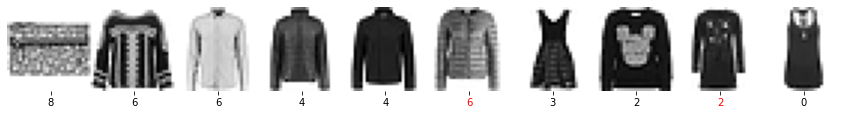

In [74]:
displayImages(images, np.argmax(yPred[randomIndexes], axis = 1), yTest[randomIndexes])